In [1]:
# все библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from itertools import product
%matplotlib inline
import seaborn
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
# считывание данных

df_pion = pd.read_csv('data/v1_pion_train.csv')
df_kaon = pd.read_csv('data/v1_kaon_train.csv')
df_electron = pd.read_csv('data/v1_electron_train.csv')
df_ghost = pd.read_csv('data/v1_ghost_train.csv')
df_muon = pd.read_csv('data/v1_muon_train.csv')
df_proton = pd.read_csv('data/v1_proton_train.csv')

In [3]:
x_cols = ['TrackP', 'TrackEta', 'NumLongTracks']
y_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']

In [4]:
def create_masks(count, features, bins):
    masks = {}
    for col in features.columns:
        mask = np.zeros((len(features[col]), count), dtype=np.bool)
        mask[:, 0], mask[:, -1] = features[col] <= bins[col][0], features[col] > bins[col][-1]
        for i in range(count - 2):
            mask[:,i+1] = (bins[col][i] < features[col]) & (features[col] <= bins[col][i+1])
        masks[col] = mask
    return masks

In [5]:
class Model:
    def train(self, X, Y, n_bins=5):
        self.means = dict.fromkeys(Y.columns, np.zeros((n_bins, n_bins, n_bins)))
        self.stds = dict.fromkeys(Y.columns, np.zeros((n_bins, n_bins, n_bins)))
        self.bins = {}
        cols = X.columns
        for col in cols:
            self.bins[col] = np.percentile(X[col], 100*np.linspace(1./n_bins, (n_bins-1)/n_bins,n_bins-1))
        self.masks = create_masks(n_bins, X, self.bins)
        
        for i in range(n_bins):
            for j in range(n_bins):
                for k in range(n_bins):
                    f_masks = np.logical_and(self.masks[cols[0]][:,i], 
                                             self.masks[cols[1]][:,j],
                                             self.masks[cols[2]][:,k]) 
                    for col in Y.columns:
                        self.means[col][i][j][k] = np.mean(Y[col][f_masks])
                        self.stds[col][i][j][k] = np.std(Y[col][f_masks])
        

    def predict(self, X):
        pred = pd.DataFrame()
        count = np.zeros((self.means['RichDLLk'].shape), dtype=np.int)
        n_bins = len(count)
        pred_masks = create_masks(n_bins, X, self.bins)
        cols = X.columns
        for i in range(n_bins):
            for j in range(n_bins):
                for k in range(n_bins):
                    count[i,j,k] = np.count_nonzero(
                        pred_masks['TrackP'][:,i] &
                        pred_masks['TrackEta'][:,j] &
                        pred_masks['NumLongTracks'][:,k])
        
        for col in self.means.keys():
            samples = np.array([])
            for i in range(n_bins):
                for j in range(n_bins):
                    for k in range(n_bins):
                        samples = np.append(samples,
                                         np.random.normal(
                                            loc=self.means[col][i][j][k],
                                            scale=self.stds[col][i][j][k],
                                            size=count[i][j][k]
                                         )
                                        )
            pred[col] = samples
        return pred

In [ ]:
for i in range(n_bins):
            for j in range(n_bins):
                for k in range(n_bins):
                    count[i][j][k] = np.count_nonzero(np.logical_and(self.masks[cols[0]][:,i],
                                                                   self.masks[cols[1]][:,j],
                                                                   self.masks[cols[2]][:,k]))

In [6]:
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

In [7]:
#https://github.com/SiLiKhon/RICH_GAN_misc/blob/master/coopetition/scoring_program/score.py

def score_func(sample1, sample2):
    score = 0
    cols = sample1.columns
    w_normal = np.random.normal(size=(100, len(cols)))
    reference = sample1.copy()[cols].values
    prediction = sample2.copy()[cols].values
    for k in range(100):
        score = max(score,
                    ks_2samp(
                        np.sum(w_normal[k] * reference, axis=1), 
                        np.sum(w_normal[k] * prediction, axis=1)
                    )[0]
                   )
    return score

In [8]:
kf = KFold(n_splits=5)

model_scores = []
best_scores  = []

for train_index, test_index in kf.split(df_pion[x_cols]):
    X_train = df_pion[x_cols].iloc[train_index]
    Y_train = df_pion[y_cols].iloc[train_index]
    X_test  = df_pion[x_cols].iloc[test_index ]
    Y_test  = df_pion[y_cols].iloc[test_index ]
  
    model = Model()
    model.train(X_train.copy(), Y_train.copy(), n_bins=5)
    Y_pred = model.predict(X_test.copy())
  
    model_scores.append(score_func(Y_test, Y_pred))
    best_scores.append(score_func(Y_test, Y_train))

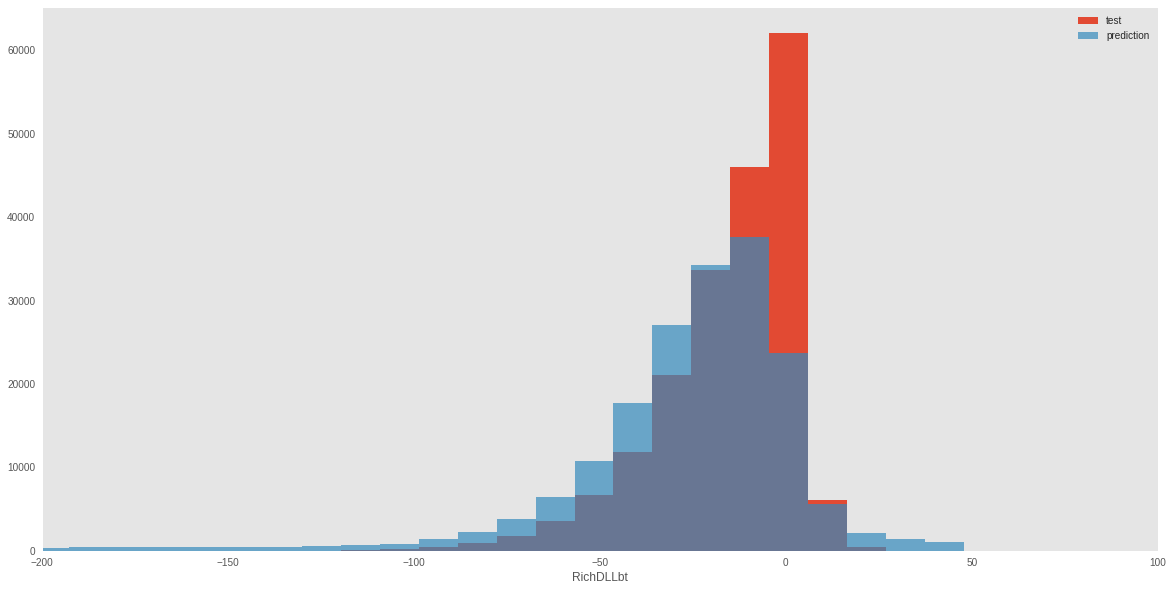

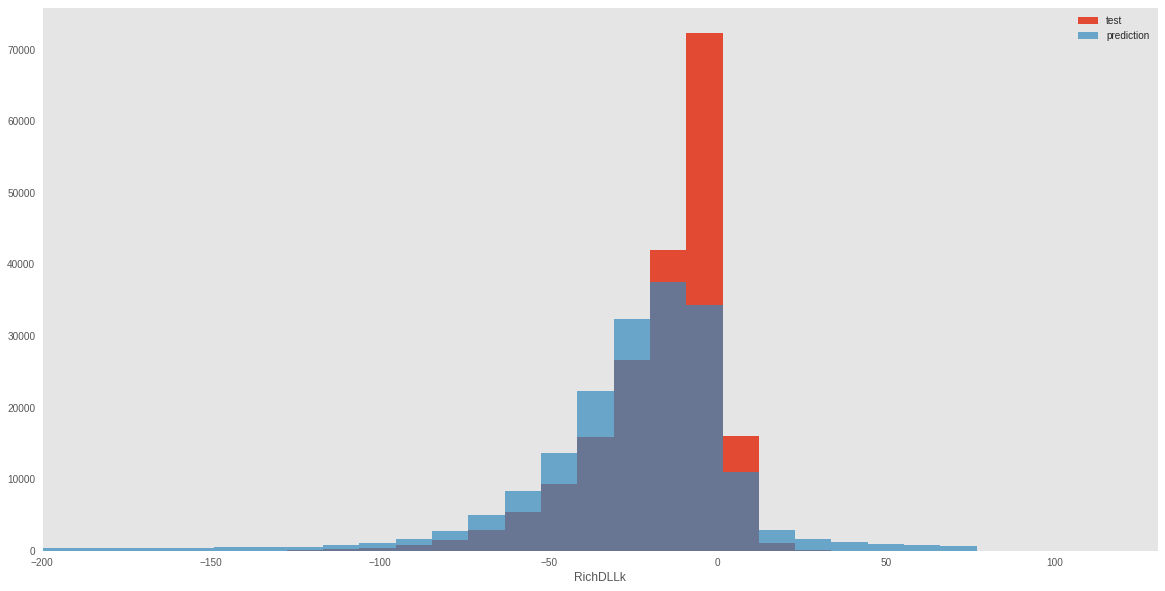

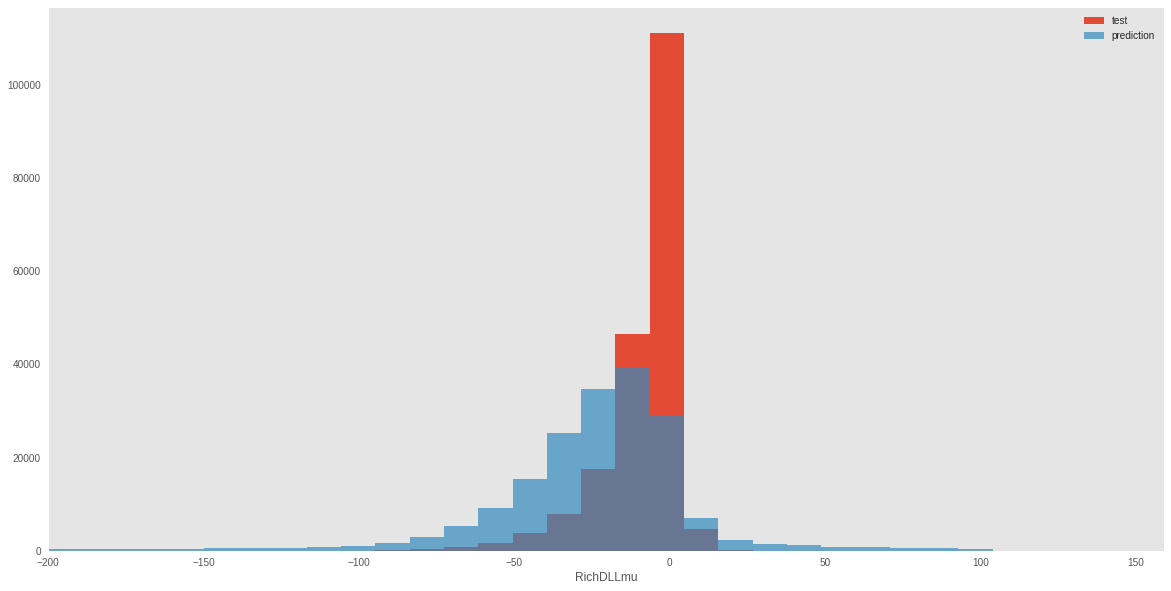

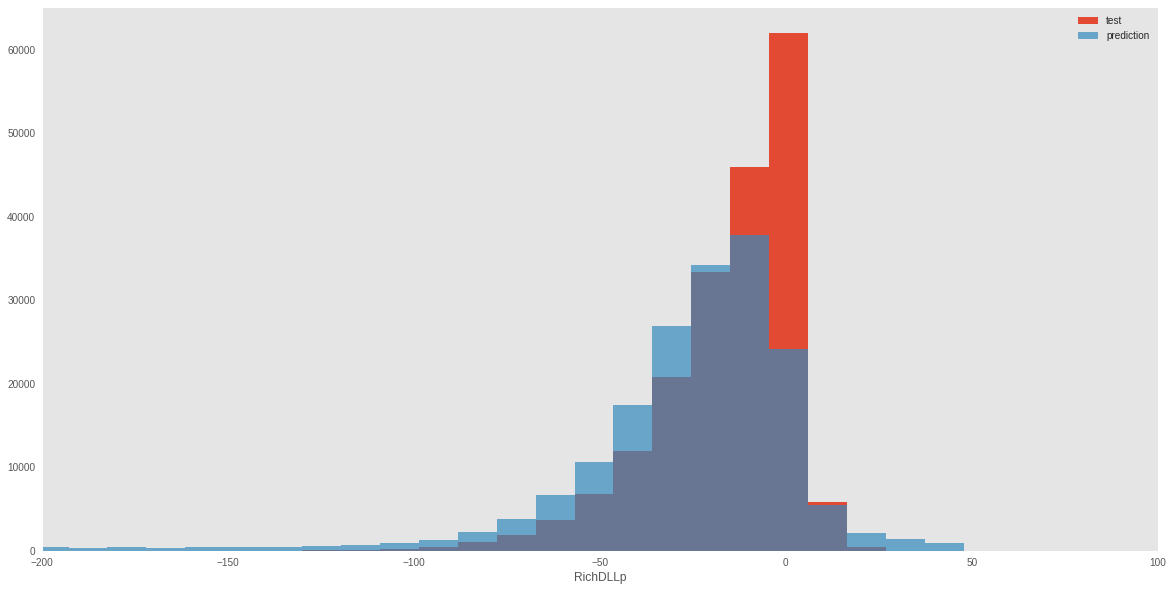

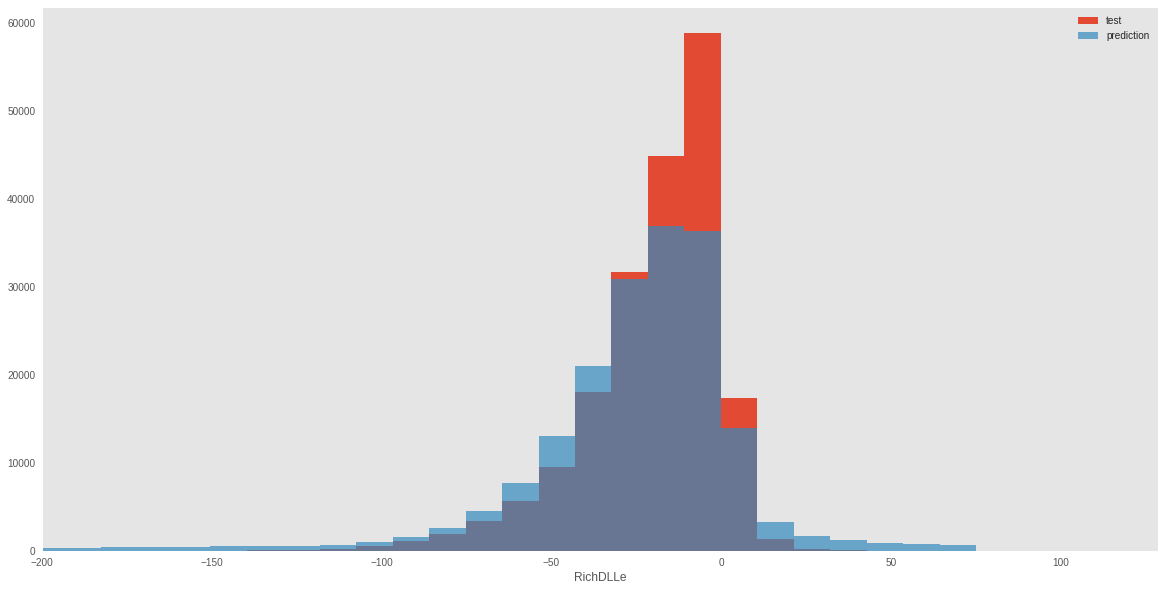

In [9]:
for col in Y_pred.columns:
    plt.subplots(figsize=(20, 10))
    plt.grid()
    _, bins, _ = plt.hist(Y_test[col], bins=100 , label='test'      )
    _, _   , _ = plt.hist(Y_pred[col], bins=bins, label='prediction', alpha=0.7)
    plt.legend(loc='best')
    plt.xlim(left=-200)
    plt.xlabel(col)
    plt.show();

In [ ]:
def train(trX, trY, col, target bins=5, n_splits=5)
    _, bound_bins = pd.cut(trX, bins, retbins=True)
    curX, curY = trX[col], trY[target]
    cur_train = pd.concat([curX, curY])
    model_scores = []
    best_scores  = []
    for i in range(1, bound_bins.shape[0]):
        kf = KFold(n_splits=n_splits)
        train_bin = cur_train.loc[(cur_train[col] > bins[i-1]) & (cur_train[col] <= bins[i])]
        for train_index, test_index in kf.split(cur_train):
            b_trX, b_trY = train_bin[col].iloc[train_index], train_bin[target].iloc[train_index]
            b_teX, b_teY = train_bin[col].iloc[test_index], train_bin[target].iloc[test_index]
            lr.fit(b_trX, b_trY)
            model_scores.append(score_func(Y_test, Y_pred))
            best_scores .append(score_func(Y_test, Y_train))
            

def test(teX, teY):